# OVERVIEW OF DATASET
**Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.**

**To overcome the limitations related to noise in Twitter datasets, this News Headlines dataset for Sarcasm Detection is collected from two news website. TheOnion aims at producing sarcastic versions of current events and we collected all the headlines from News in Brief and News in Photos categories (which are sarcastic). We collect real (and non-sarcastic) news headlines from HuffPost.**

**The dataset consists about 28000 text data points where each data category belongs to 2 category - Sarcastic or Not Sarcastic**

**We will use RNN lstm model for making predictions - Word2Vec Embeddings**. 

# Import Libraries

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from tensorflow.keras.preprocessing import text, sequence
from sklearn.model_selection import train_test_split
from string import punctuation
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional
from tensorflow import keras
import gensim
import warnings
warnings.filterwarnings("ignore")

# Dataset Loader

In [47]:
path1 ="Sarcasm_Headlines_Dataset.json"
path2 ="Sarcasm_Headlines_Dataset_v2.json"
class DataFrame_Loader():

    
    def __init__(self,lines):
        self.lines = lines
        
        print("Loadind DataFrame")
        
    def load_json_files(self,path1,path2):
        dftrain = pd.read_json(path1,lines=True)
        dftest = pd.read_json(path2,lines=True)
        return dftrain,dftest

In [48]:
load= DataFrame_Loader(True)
df1,df2 = load.load_json_files(path1,path2)
df1.shape,df2.shape

Loadind DataFrame


((26709, 3), (28619, 3))

In [49]:
df1 = df1[['headline','is_sarcastic']]
df1.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


# Data Preprocessing

In [50]:
StopWords = set(stopwords.words('english'))
Punctuation = list(string.punctuation)
StopWords.update(Punctuation)

In [51]:
class  Basic_Data_Cleaning():
    
    
    
    def __init__(self):
        
        
        print("Cleaning Object Initiated")
        
        
        
    def strip_html(self,text):
        
        """
        Parsing the 
        text with BS4
        """
        
        soup = BeautifulSoup(text, "html.parser")
        
        return soup.get_text()

    
    def remove_between_square_brackets(self,text):
        
        """
        Removing the 
        square brackets
        """
        
        return re.sub('\[[^]]*\]', '', text)
    

    def remove_between_square_brackets(self,text):
        """
        Removing URL's
        """
        return re.sub(r'http\S+', '', text)
    

    def remove_stopwords(self,text):
        
        """
        Removing the 
        stopwords from text
        """
        
        final_text = []
        
        for i in text.split():
            
            if i.strip().lower() not in StopWords:
                
                final_text.append(i.strip())
                
        return " ".join(final_text)

    
    def denoise_text(self,text):
        
        """
        Removing the 
        noisy text
        """
        
        text = self.strip_html(text)
        
        text = self.remove_between_square_brackets(text)
        
        text = self.remove_stopwords(text)
        
        return text
    
    def Apply_denoise_text(self):
    
        """ 
        Apply function 
        on review column
        """
        return df1['headline'].apply(self.denoise_text)

In [52]:
DC = Basic_Data_Cleaning()

Cleaning Object Initiated


In [53]:
df1['headline'] = DC.Apply_denoise_text()
df1.head()

,headline,is_sarcastic
0,former versace store clerk sues secret 'black ...,0
1,'roseanne' revival catches thorny political mo...,0
2,mom starting fear son's web series closest thi...,1
3,"boehner wants wife listen, come alternative de...",1
4,j.k. rowling wishes snape happy birthday magic...,0


# WordCloud

In [180]:
def wordcloud(x,num):
    plt.figure(figsize=(14, 10))
    wordcloud = WordCloud(width = 1000, height = 500).generate(" ".join(df1[df1.is_sarcastic == num].headline))
    plt.imshow(wordcloud)
    plt.axis("off")
    return wordcloud

When Sarcastic = 0 <wordcloud.wordcloud.WordCloud object at 0x00000163D8311640>
When Sarcastic = 1 <wordcloud.wordcloud.WordCloud object at 0x00000163DBB01760>


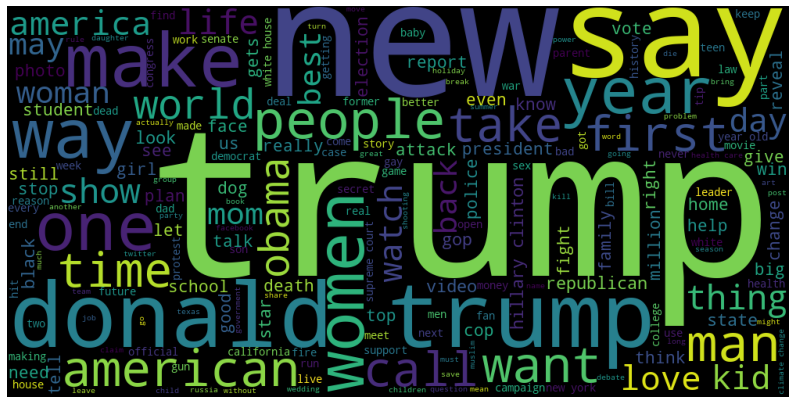

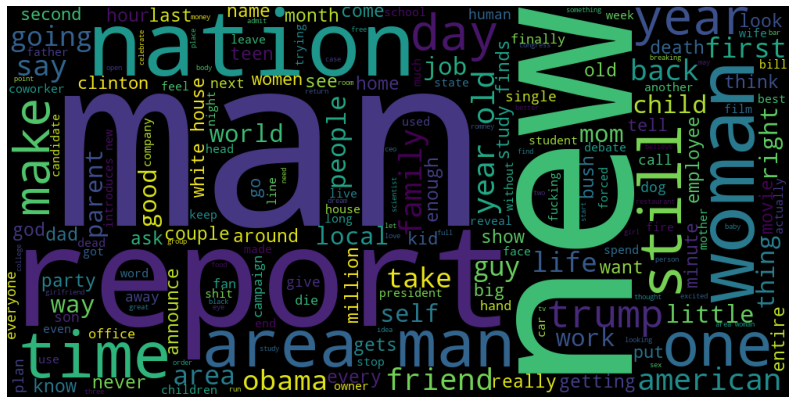

In [53]:
print("When Sarcastic = 0",wordcloud(df1,0))
print("When Sarcastic = 1",wordcloud(df1,1))

# Word2Vec Embedding Feature Representation

In [54]:
class Word_Embedding():
    
    
    def __init__(self,
                 
                 size,
                 
                 window,
                 
                 min_count):
        
        self.size = 200
        
        self.window = 5
        
        self.min_count = 1
        
        
        
        print("Embedding Object Created")
        
        
    def Word_Embedding(self,df):
    
        words = []
        
        for i in df.headline.values:
            
            words.append(i.split())
            
        w2v_model = gensim.models.Word2Vec(sentences = words,size = self.size , window = self.window , min_count = self.min_count)
        
        return w2v_model,words
    
    def Tokenization_of_Wodrs(self,words,num_words):
    
        tokenizer = text.Tokenizer(num_words=num_words)
        
        tokenizer.fit_on_texts(words)
        
        tokenized_train = tokenizer.texts_to_sequences(words)
        
        x = sequence.pad_sequences(tokenized_train, maxlen = 20)
        
        vocab = tokenizer.word_index
        
        vocab_size = len(tokenizer.word_index) + 1
        
        return x,vocab,vocab_size
    
    def get_weight_matrix(self,model, vocab, EMBEDDING_DIM):

        vocab_size = len(vocab) + 1

        weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))

        for word, i in vocab.items():
            
            weight_matrix[i] = model[word]
            
        return weight_matrix

In [55]:
WE = Word_Embedding(200,5,1)

Embedding Object Created


In [56]:
w2v_model,words = WE.Word_Embedding(df1)

In [57]:
x,vocab,vocab_size = WE.Tokenization_of_Wodrs(words,35000)

In [58]:
embedding_vectors = WE.get_weight_matrix(w2v_model,vocab,200)

In [59]:
x_train, x_test, y_train, y_test = train_test_split(x, df1.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [60]:
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((18696, 20), (8013, 20), (18696,), (8013,))

# RNN Bidirectional lstm Model

In [61]:
input_length =20
output_length= 200
def build_rnn(vocab_size,output_dim, max_len):

    model = Sequential([
        keras.layers.Embedding(vocab_size,output_dim=output_length,
                              input_length=input_length),
        keras.layers.BatchNormalization(),
        keras.layers.Bidirectional(keras.layers.LSTM(256,return_sequences=True)),
        keras.layers.GlobalMaxPool1D(),
        keras.layers.Dense(256),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(158),
        keras.layers.Dropout(0.3),
        keras.layers.Dense(90),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(60),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(32),
        keras.layers.Dense(output_dim, activation='sigmoid')
    ])

    return model

rnn_model = build_rnn(vocab_size, 1, input_length)

rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

rnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 20, 200)           7287400   
_________________________________________________________________
batch_normalization_4 (Batch (None, 20, 200)           800       
_________________________________________________________________
bidirectional_8 (Bidirection (None, 20, 512)           935936    
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 512)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 158)              

In [62]:
rnn_model.fit(x_train, y_train, batch_size = 256 , validation_data = (x_test,y_test) , epochs = 50)

score = rnn_model.evaluate(x_train, y_train, verbose=1)

print("Loss:%.3f Accuracy: %.3f" % (score[0], score[1]))

Epoch 1/50
74/74 [==============================] - 32s 434ms/step - loss: 0.6348 - acc: 0.6527 - val_loss: 0.6496 - val_acc: 0.7499
Epoch 2/50
74/74 [==============================] - 34s 460ms/step - loss: 0.2518 - acc: 0.8974 - val_loss: 0.6134 - val_acc: 0.8013
Epoch 3/50
74/74 [==============================] - 34s 458ms/step - loss: 0.0660 - acc: 0.9769 - val_loss: 0.5095 - val_acc: 0.7842
Epoch 4/50
74/74 [==============================] - 34s 463ms/step - loss: 0.0213 - acc: 0.9933 - val_loss: 0.4893 - val_acc: 0.7665
Epoch 5/50
74/74 [==============================] - 34s 460ms/step - loss: 0.0217 - acc: 0.9919 - val_loss: 0.5034 - val_acc: 0.7945
Epoch 6/50
74/74 [==============================] - 34s 461ms/step - loss: 0.0082 - acc: 0.9974 - val_loss: 0.8174 - val_acc: 0.7745
Epoch 7/50
74/74 [==============================] - 37s 501ms/step - loss: 0.0391 - acc: 0.9869 - val_loss: 0.7487 - val_acc: 0.7851
Epoch 8/50
74/74 [==============================] - 38s 508ms/step - 

In [69]:
ypred = rnn_model.predict_classes(x_test)
ypred = pd.DataFrame(ypred,columns=['pred'])
ypred.head()

,pred
0,1
1,1
2,1
3,0
4,1


In [42]:
ypred.shape,y_test.shape,x_test.shape

((8013, 1), (8013,), (8013, 20))

In [70]:
ypred.value_counts()

pred
0       4503
1       3510
dtype: int64

In [66]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print(metrics.accuracy_score(y_test, ypred))
        
print(metrics.confusion_matrix(y_test, ypred))
        
print(metrics.classification_report(y_test, ypred))

0.7807313116186197
[[3615  868]
 [ 889 2641]]
              precision    recall  f1-score   support

           0       0.80      0.81      0.80      4483
           1       0.75      0.75      0.75      3530

    accuracy                           0.78      8013
   macro avg       0.78      0.78      0.78      8013
weighted avg       0.78      0.78      0.78      8013

